To install new library (since everything is running on kernel python3.10): 

/$ python3.10 -m pip install *pandas*

In [2]:
# import all files from necessary directory
from os import listdir
import os
from os.path import isfile, join
dir = "/data/Riabova/train3"
all_files = [join(dir, f) for f in listdir(dir)]
all_files_mhd = [string for string in all_files if string.endswith("mhd")]
len(all_files_mhd)

288

In [3]:
import numpy as np

''' 
Example usage:
    coords_1 = [x1, x2, x3]  # Replace x1, x2, x3 with the actual values
    method = "hex2us"  # Or "us2hex"
    isShifted = True  # Or False
    coords_2 = transformTo(coords_1, method, isShifted) 

'''

def transformTo(coords_1, method, isShifted):
    # Transformation matrices
    T_needle_tip = np.array([[-0.1601, 3.1823, 0.1383, 13.8778],
                            [0.0178, 0.0806, -3.3695, 112.5630],
                            [-2.4504, -0.1146, -0.3139, 110.3655],
                            [-0.0000, -0.0000, -0.0000, 1.0000]])

    T_needle_tip_shifted = np.array([[-0.1601, 3.1823, 0.1383, 20.8778],
                                     [0.0178, 0.0806, -3.3695, 109.5630],
                                     [-2.4504, -0.1146, -0.3139, 110.3655],
                                     [-0.0000, -0.0000, -0.0000, 1.0000]])

    if isShifted:
        T = T_needle_tip_shifted
    else:
        T = T_needle_tip

    coords_1 = np.append(coords_1, 1)  # Add 1 to coords_1

    if method == "hex2us":
        coords_2 = np.dot(T, coords_1.T)
    else:
        coords_2 = np.linalg.solve(T, coords_1.T)  # Equivalent to inv(T) * coords_1.T

    coords_2 = coords_2.T
    coords_2 = coords_2[:-1]

    return coords_2


def transformToUS(coords_1):
    return transformTo(coords_1, "hex2us", True)

In [4]:
import numpy as np

def get_labels(f, info):
    
    labels = np.zeros((info['Dimensions'][3], 3))
        
    for frame in range(0, info['Dimensions'][3]):
        if frame > 9:
            info_frame_timestamp_field = "Seq_Frame00" + str(frame) + "_Timestamp"
        else:
            info_frame_timestamp_field = "Seq_Frame000" + str(frame) + "_Timestamp"
            
        frame_timestamp = float(info[info_frame_timestamp_field])
        
        # filename in format 'x_y_z_alpha_beta_gamma_velocity_axis_timestamp
        filename = f.split("/")[-1].split(".")[0] # 0_22_5_0_0_0_3_1_1686308127391259
        frame_timestamp_micros = frame_timestamp*1000000 #in microseconds, correct
        
         # extract params from filename
        filename_params = filename.split('_')
        start_timestamp_micros = float(filename_params[-1]) # in micros
        axis = int(filename_params[-2])
        velocity = int(filename_params[-3])  # in mm/s

        # get tip coords in hexapode system
        dt = frame_timestamp_micros - start_timestamp_micros  # in micros
        distance = velocity * dt / 1000000  # in mm
        hex_coords = [0, 0, 0]
        for i in range(3):
            hex_coords[i] = float(filename_params[i])
            if axis == i+1:
                hex_coords[i] += distance
                        
        # get tip coords in US system
        labels[frame, :] = transformToUS(hex_coords)
        
    return labels

In [15]:
from utils.type_reader import mha_read_header
import numpy as np
from tqdm import tqdm

# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
labels = np.empty((1, 3))
i = 0
for f in all_files_mhd:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    info = mha_read_header(f)
    labels = np.concatenate((labels, get_labels(f, info)), axis = 0)
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*info['Dimensions'][3]), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, info['Dimensions'][3])), axis=0)
    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
labels = labels[1:, :]
frame_nums = frame_nums[1:]

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...
File 120...
File 140...
File 160...
File 180...
File 200...
File 220...
File 240...
File 260...
File 280...


In [16]:
# print(labels.shape)
# print(all_frames_filenames_array.shape)
# print(frame_nums.shape)

(17717, 3)
(17717,)
(17717,)


In [51]:
from utils.type_reader import get_image_array
input_image = get_image_array(all_files_mhd[0])[:, :, :, 4]

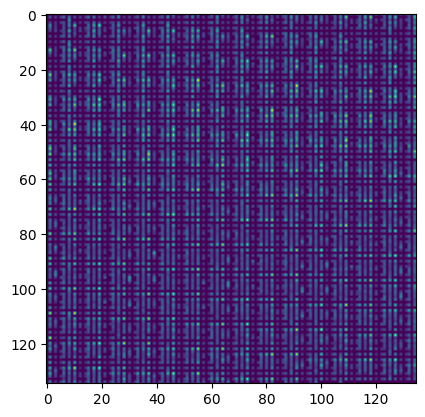

In [50]:
from PIL import Image
import matplotlib.pyplot as plt

formatted = (input_image * 255 / np.amax(input_image)).astype('uint8')
img = Image.fromarray(formatted[:, :, 60])
plt.imshow(img)
plt.show()

###########################################
# TODO: Fix how to display frames correctly!
###########################################

In [12]:
import tensorflow as tf
import numpy as np
from utils.type_reader import get_image_array


'''Construct a data generator using tf.Dataset'''

###############################
# TODO: check if this is working
###############################

def convert_to_tf_dataset(frame_filenames, frame_nums, labels, batch_size=64):
    # TODO: apply some augmentation (rotation, flipping)

    def normalize(input_image):
        input_image = tf.cast(input_image, tf.float32) / 255.0
        return input_image

    def load_images(datapoint):
        # create frame image based on frame number and filename
        input_image = normalize(get_image_array(datapoint['frame_filename'])[:, :, :, datapoint['frame_num']])

        # create mask for the frame image
        us_tip_coords = datapoint['label']
        mask_radius = 3 # since resolution is 3px=mm and we have +-1mm error, mask should be 3px radius
        mask_image = np.zeros((input_image.shape))
        mask_image[
            us_tip_coords[0]-mask_radius:us_tip_coords[0]+mask_radius, 
            us_tip_coords[1]-mask_radius:us_tip_coords[1]+mask_radius, 
            us_tip_coords[2]-mask_radius:us_tip_coords[2]+mask_radius
        ] = np.full((mask_radius*2, mask_radius*2,mask_radius*2), 1)
        
        return input_image, mask_image

    dataset = tf.data.Dataset.from_tensor_slices({
        'frame_filename': frame_filenames, 
         'frame_num': frame_nums, 
         'label': labels
    })
    
    dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
    batches = (dataset.cache().shuffle(100).batch(batch_size).repeat().prefetch(buffer_size=tf.data.AUTOTUNE))

    return batches